In [5]:
import pandas as pd
import numpy as np
import pickle

from os import path as osp

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from thundersvm import SVC
# from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

csv_folder = './csv/'
SUBSETS_DIR = './subsets/'
random_state=0

In [6]:
from thundersvm_tmp import SVC

OSError: dlopen(./libthundersvm.so, 6): no suitable image found.  Did find:
	./libthundersvm.so: unknown file type, first eight bytes: 0x7F 0x45 0x4C 0x46 0x02 0x01 0x01 0x03
	/Users/anhleu/Desktop/lidc-luna/libthundersvm.so: unknown file type, first eight bytes: 0x7F 0x45 0x4C 0x46 0x02 0x01 0x01 0x03

## Get features and label

In [146]:
df = pd.read_csv(csv_folder+'feat_luna_sel.csv')
i=0
for name in (list(df)):
    print(i, name)
    i+=1

0 seriesuid
1 coordX
2 coordY
3 coordZ
4 diameter_mm
5 malignant
6 SeriesInstanceUID
7 PatientID
8 StudyInstanceUID
9 approx_roi
10 pkl_id
11 shape_MajorAxisLength
12 shape_SurfaceVolumeRatio
13 shape_VoxelVolume
14 firstorder_Kurtosis
15 firstorder_RootMeanSquared
16 firstorder_Skewness
17 glcm_SumEntropy
18 glrlm_LongRunHighGrayLevelEmphasis
19 glszm_GrayLevelNonUniformity
20 ngtdm_Busyness


In [147]:
X = df[list(df)[11:]].to_numpy()
y = df['malignant'].to_numpy()
identifier = df['seriesuid'].to_numpy()
print(len(y))

749


In [148]:
fold = [0,1,2,3,4]
teidlsts = []
for test_fold in fold:
    print(test_fold)
    teidlst = []
    with open(osp.join(SUBSETS_DIR, "subset{}.txt".format(str(test_fold)))) as fo:
        teidlst += [i.strip() for i in fo.readlines()]
    teidlsts.append(teidlst)
print(np.shape(teidlsts))

0
1
2
3
4
(5, 89)


## Features visualization

In [153]:
f = list(df)[11:]

df_X = df[f]
df_X = df_X.apply (pd.to_numeric, errors='coerce')
df_X = df_X.dropna()

df_y = df['malignant']

# f.remove('shape_SurfaceVolumeRatio')
# f.remove( 'glszm_GrayLevelNonUniformity')

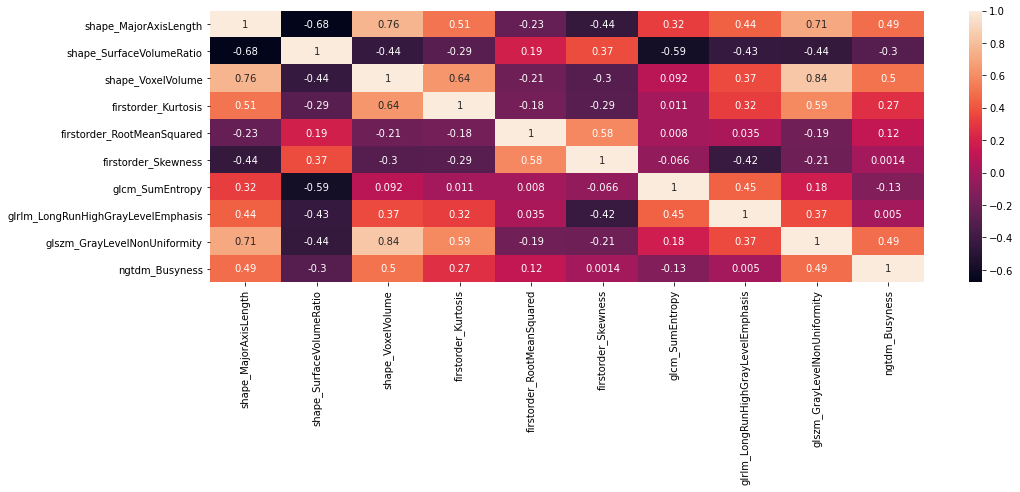

NameError: name 'figroot' is not defined

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# X = df[list(df)[11:]].to_numpy()
# y = df['malignant'].to_numpy()

plt.figure(figsize = (16,5))

corrMatrix = df_X.corr()
a = sns.heatmap(corrMatrix, annot=True)
figure = a.get_figure()    
plt.show()
# figure.savefig(figroot+'corr.png', dpi=400)

In [155]:
corr=np.array(corrMatrix)
n,m = np.shape(corr)
thres=0.80
for i in range (n):
    for j in range (m):
        if ((corr[i,j]>thres or corr[i,j]<-thres) and i!=j):
            print(corr[i,j],'\t',i,j,'\t', f[i],'\t', f[j])

0.8365529495356787 	 2 8 	 shape_VoxelVolume 	 glszm_GrayLevelNonUniformity
0.8365529495356787 	 8 2 	 glszm_GrayLevelNonUniformity 	 shape_VoxelVolume


In [156]:
corr=corrMatrix
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df_X.columns[columns]
df_X = df_X[selected_columns]
print(selected_columns)
df_X

Index(['shape_MajorAxisLength', 'shape_SurfaceVolumeRatio',
       'shape_VoxelVolume', 'firstorder_Kurtosis',
       'firstorder_RootMeanSquared', 'firstorder_Skewness', 'glcm_SumEntropy',
       'glrlm_LongRunHighGrayLevelEmphasis', 'glszm_GrayLevelNonUniformity',
       'ngtdm_Busyness'],
      dtype='object')


,shape_MajorAxisLength,shape_SurfaceVolumeRatio,shape_VoxelVolume,firstorder_Kurtosis,firstorder_RootMeanSquared,firstorder_Skewness,glcm_SumEntropy,glrlm_LongRunHighGrayLevelEmphasis,glszm_GrayLevelNonUniformity,ngtdm_Busyness
0,7.824012,1.255804,144.843525,2.071653,791.600790,0.313082,3.441172,29.758931,4.120000,1.451791
1,5.363270,1.671977,49.218674,2.457984,529.284935,0.339971,4.252558,168.160116,2.923077,0.096922
2,4.582082,2.546831,25.495605,2.125554,638.843943,-0.069593,2.191387,22.146999,1.444444,0.201618
3,14.636532,1.733728,154.035950,2.448939,656.581675,0.205217,4.194419,79.564551,5.360656,0.236687
4,5.563623,1.728140,44.096375,3.126417,619.404689,0.410709,4.512484,397.591417,2.803279,0.069333
...,...,...,...,...,...,...,...,...,...,...
744,10.175263,0.993706,313.257122,2.694633,291.583548,-0.744897,5.425990,1472.233099,17.135458,0.082773
745,6.437173,1.800659,60.248452,2.229608,532.402812,0.200251,5.322613,420.381118,4.416667,0.051715
746,4.810746,2.373425,23.828125,3.864097,190.019024,-1.110286,3.931938,526.373913,2.000000,0.022287
747,6.303950,1.370698,86.519929,1.498703,513.748716,-0.031352,4.980739,516.342958,3.051948,0.058925


In [157]:
import statsmodels.api as sm
selected_columns = selected_columns[1:].values
# ['shape_MajorAxisLength',
#  'shape_MeshVolume',
#  'shape_Sphericity',
#  'shape_SurfaceVolumeRatio',
#  'firstorder_Entropy',
#  'firstorder_InterquartileRange',
#  'firstorder_Skewness',
#  'firstorder_TotalEnergy',
#  'glcm_Imc1',
#  'glcm_JointEntropy',
#  'gldm_DependenceNonUniformity',
#  'gldm_DependenceVariance',
#  'gldm_GrayLevelNonUniformity',
#  'glrlm_LongRunHighGrayLevelEmphasis',
#  'glrlm_RunLengthNonUniformityNormalized',
#  'glszm_SizeZoneNonUniformityNormalized',
#  'ngtdm_Coarseness']


In [158]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(df_X.iloc[:,1:].values, df_X.iloc[:,0].values, SL, selected_columns)



In [162]:
result = pd.DataFrame()
result['diagnosis'] = df['malignant']
data = pd.DataFrame(data = data_modeled, columns = selected_columns)
list(data)

['shape_SurfaceVolumeRatio',
 'shape_VoxelVolume',
 'firstorder_RootMeanSquared',
 'firstorder_Skewness',
 'glcm_SumEntropy',
 'glrlm_LongRunHighGrayLevelEmphasis',
 'glszm_GrayLevelNonUniformity',
 'ngtdm_Busyness']

/Users/anhleu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anhleu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/anhleu/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

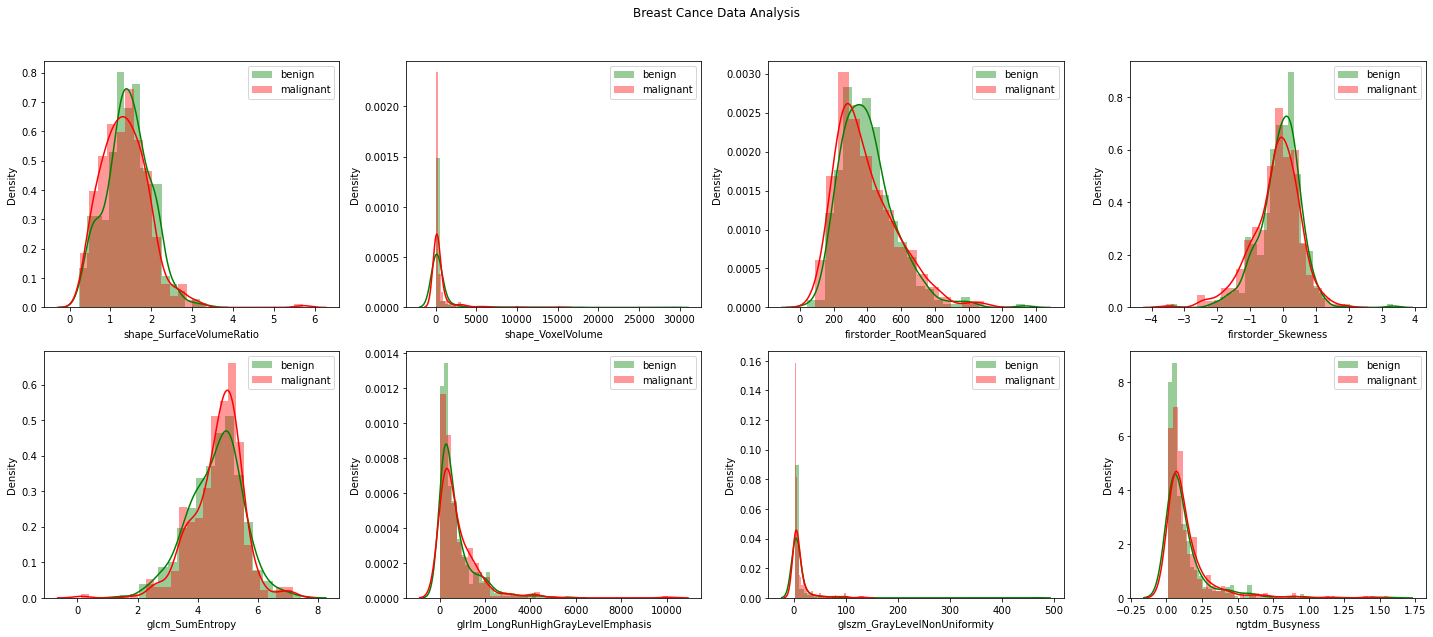

<Figure size 432x288 with 0 Axes>

In [163]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(data[i][result['diagnosis']==0], color='g', label = 'benign')
    sns.distplot(data[i][result['diagnosis']==1], color='r', label = 'malignant')
    plt.legend(loc='best')
fig.suptitle('Breast Cance Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()
plt.savefig('rad.png')


## Pick the best hyper-parameters

In [6]:
fold = 4
teidlst = teidlsts[fold]

X_train = []
X_test = []
y_train = []
y_test = []
for i in range(len(y)):
    srsid = identifier[i]
    if srsid.split('-')[0] in teidlst:
        y_test.append(int(y[i]))
        X_test.append(X[i])
    else:
        y_train.append(int(y[i]))
        X_train.append(X[i])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(671, 10)
(78, 10)
(671,)
(78,)


In [8]:
pipe = make_pipeline(SimpleImputer(), StandardScaler(), SVC(random_state=random_state))

pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'svc', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__gpu_id', 'svc__kernel', 'svc__max_iter', 'svc__max_mem_size', 'svc__n_jobs', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [10]:
folds = [0,1,2,3,4]
for test_fold in folds:
    print('Fold:',test_fold)
    teidlst = teidlsts[test_fold]

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(len(y)):
        srsid = identifier[i]
        if srsid.split('-')[0] in teidlst:
            y_test.append(int(y[i]))
            X_test.append(X[i])
        else:
            y_train.append(int(y[i]))
            X_train.append(X[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
        
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

    classifier_types = ['gradient_boosting', 'rf', 'logistic_regression', 'svm']
    
    for classifier_type in classifier_types:
        print(classifier_type)
        if(classifier_type =='gradient_boosting'):
            continue
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), GradientBoostingClassifier())
            param_grid = {"gradientboostingclassifier__loss":['deviance', 'exponential'],
                          "gradientboostingclassifier__learning_rate":[10, 1, 0.1, 0.01, 0.001],
                          "gradientboostingclassifier__n_estimators":[100, 1000]}

        elif(classifier_type =='rf'):
            continue
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), RandomForestClassifier())
            param_grid = {"randomforestclassifier__criterion":['gini', 'entropy'],
                          "randomforestclassifier__max_features":['auto', 'sqrt', 'log2']}

        elif(classifier_type =='logistic_regression'):
            continue
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression())
            param_grid = {'logisticregression__C':[0.1,1,100,1000],
                          "logisticregression__penalty":['l1', 'l2', 'elasticnet'],
                          "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

        elif(classifier_type =='svm'):
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), SVC(verbose=True))
            param_grid = {'svc__C':[0.1,1,100,1000],
                          'svc__kernel':['linear', 'polynomial', 'rbf'],
                          'svc__degree':[1,2,3,4,5,6],
                          'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
            

        cv = KFold(n_splits=10, shuffle=True)
        gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv, n_jobs=4)
        gcv.fit(X_train, y_train)

        results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
        print(results.loc[:, ~results.columns.str.endswith("_time")][:3])
        results.loc[:, ~results.columns.str.endswith("_time")][:10].to_csv(classifier_type+'_'+str(test_fold)+'_feat_sel.csv')
        best_model = pipe.set_params(**gcv.best_params_)
        print(best_model)

        pipe.fit(X_train, y_train)
        print(pipe.score(X_train, y_train))
        print(pipe.score(X_test, y_test))


Fold: 0
gradient_boosting
rf
logistic_regression
svm


KeyboardInterrupt: 

In [ ]:
df_score= []
df_C = []
df_kernel = []
df_degree = []
df_gamma = []
fold = [0]
for test_fold in fold:
    teidlst = []
    with open(osp.join(SUBSETS_DIR, "subset{}.txt".format(str(test_fold)))) as fo:
        teidlst += [i.strip() for i in fo.readlines()]

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(len(y)):
        srsid = identifier[i]
        if srsid.split('-')[0] in teidlst:
            y_test.append(int(y[i]))
            X_test.append(X[i])
        else:
            y_train.append(int(y[i]))
            X_train.append(X[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    for svc__C in [0.1,1,100,1000]:
        for svc__kernel in ['linear', 'polynomial', 'rbf']:
            for svc__degree in [1,2,3,4]:
                for svc__gamma in [1, 0.1, 0.01, 0.001, 0.0001]:                
                    pipe = make_pipeline(SimpleImputer(), StandardScaler(), SVC(C=svc__C, kernel=svc__kernel, degree=svc__degree, gamma=svc__gamma))
                    scores = cross_val_score(pipe, X_train, y_train, cv=10)
                    df_score.append(np.mean(scores))
                    df_C.append((svc__C))
                    df_kernel.append((svc__kernel))
                    df_degree.append((svc__degree))
                    df_gamma.append((svc__gamma))
                    print(np.mean(scores), ':', svc__C, svc__kernel, svc__degree, svc__gamma)

                
df = pd.DataFrame(list(zip(df_score, df_C, df_kernel, df_degree, df_gamma)),
               columns =['mean_score', 'C', 'kernel', 'degree', 'gamma'])
results = df.sort_values(by='mean_score', ascending=False)
print(results.loc[:10])
results.loc[:, ~results.columns.str.endswith("_time")][:10]# .to_csv(classifier_type+'_'+str(test_fold)+'_feat_sel.csv')


## Train and test based on the best hyperparameters

In [11]:
train_scores_gb = []
test_scores_gb = []
train_scores_lr = []
test_scores_lr = []
train_scores_rf = []
test_scores_rf = []
train_scores_svm = []
test_scores_svm = []

train_scores = []
test_scores = []

fold = [0,1,2,3,4]
classifier_types = ['gradient_boosting', 'rf', 'logistic_regression', 'svm']

for test_fold in fold:
    print('test fold:', test_fold)

    teidlst = []
    with open(osp.join(SUBSETS_DIR, "subset{}.txt".format(str(test_fold)))) as fo:
        teidlst += [i.strip() for i in fo.readlines()]

    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(len(y)):
        srsid = identifier[i]
        if srsid.split('-')[0] in teidlst:
            y_test.append(int(y[i]))
            X_test.append(X[i])
        else:
            y_train.append(int(y[i]))
            X_train.append(X[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    
    for classifier_type in classifier_types:
        if classifier_type =='gradient_boosting':
            print('gradient_boosting')
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), GradientBoostingClassifier(learning_rate=1, loss='deviance', n_estimators=100))
        elif(classifier_type =='rf'):
            print('rf')
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), RandomForestClassifier(max_features='sqrt', verbose=True))
        elif(classifier_type =='logistic_regression'):
            print('logistic_regression')
            pipe = make_pipeline(SimpleImputer(), StandardScaler(),LogisticRegression(C=100, penalty='l2', solver='saga'))
        elif(classifier_type =='svm'):
            print('svm')
            pipe = make_pipeline(SimpleImputer(), StandardScaler(), SVC(random_state=random_state, C=1, kernel='polynomial', degree=2, gamma=0.1))     
            with open('svm_'+str(test_fold)+'.pickle', 'wb') as f:
                pickle.dump(print, f)

        pipe.fit(X_train, y_train)
        train_score = pipe.score(X_train, y_train)
        test_score = pipe.score(X_test, y_test)
        
        if classifier_type =='gradient_boosting':
            train_scores_gb.append(train_score)
            test_scores_gb.append(test_score)
        elif(classifier_type =='rf'):
            train_scores_rf.append(train_score)
            test_scores_rf.append(test_score)
        elif(classifier_type =='logistic_regression'):
            train_scores_lr.append(train_score)
            test_scores_lr.append(test_score)
        elif(classifier_type =='svm'):
            train_scores_svm.append(train_score)
            test_scores_svm.append(test_score)

        train_scores.append(train_score)
        test_scores.append(test_score)
        print('train score:', train_score)
        print('test score:', test_score)
    print()

test fold: 0
gradient_boosting
train score: 0.9985380116959064
test score: 0.5076923076923077
rf


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/home/eric/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


train score: 0.9985380116959064
test score: 0.46153846153846156
logistic_regression
train score: 0.6067251461988304
test score: 0.4153846153846154
svm
train score: 0.5877192982456141
test score: 0.38461538461538464

test fold: 1
gradient_boosting
train score: 0.9969924812030075
test score: 0.5238095238095238
rf
train score: 0.9969924812030075
test score: 0.44047619047619047
logistic_regression
train score: 0.5924812030075188
test score: 0.5476190476190477
svm


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/home/eric/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


train score: 0.5774436090225564
test score: 0.5357142857142857

test fold: 2
gradient_boosting
train score: 0.9970282317979198
test score: 0.5263157894736842
rf


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/home/eric/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


train score: 0.9970282317979198
test score: 0.5131578947368421
logistic_regression
train score: 0.5794947994056464
test score: 0.618421052631579
svm
train score: 0.5720653789004457
test score: 0.5657894736842105

test fold: 3
gradient_boosting
train score: 0.9970326409495549
test score: 0.5066666666666667
rf


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/home/eric/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


train score: 0.9970326409495549
test score: 0.5333333333333333
logistic_regression
train score: 0.5741839762611276
test score: 0.6133333333333333
svm
train score: 0.5741839762611276
test score: 0.5866666666666667

test fold: 4
gradient_boosting
train score: 0.9970193740685543
test score: 0.5128205128205128
rf
train score: 0.9970193740685543
test score: 0.47435897435897434
logistic_regression
train score: 0.5827123695976155
test score: 0.5384615384615384
svm
train score: 0.5797317436661699
test score: 0.47435897435897434



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
/home/eric/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [12]:
print('mean train_scores:', np.mean(train_scores_gb))
print('mean test_scores:', np.mean(test_scores_gb))

print('mean train_scores:', np.mean(train_scores_rf))
print('mean test_scores:', np.mean(test_scores_rf))

print('mean train_scores:', np.mean(train_scores_lr))
print('mean test_scores:', np.mean(test_scores_lr))

print('mean train_scores:', np.mean(train_scores_svm))
print('mean test_scores:', np.mean(test_scores_svm))

print('mean train_scores:', np.mean(train_scores))
print('mean test_scores:', np.mean(test_scores))

mean train_scores: 0.9973221479429887
mean test_scores: 0.5154609600925391
mean train_scores: 0.9973221479429887
mean test_scores: 0.4845729708887604
mean train_scores: 0.5871194988941478
mean test_scores: 0.5466439174860227
mean train_scores: 0.5782288012191826
mean test_scores: 0.5094289570079044
mean train_scores: 0.7899981489998268
mean test_scores: 0.5140267013688067
